<a href="https://colab.research.google.com/github/Anandharajan/CWT/blob/main/combined_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import glob
import os
import pandas as pd   
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('/content', "*.csv"))))

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182606 entries, 0 to 13734
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Symbol                          182592 non-null  object 
 1   Trade Type                      182592 non-null  object 
 2   Entry DateTime                  182592 non-null  object 
 3   Exit DateTime                   182592 non-null  object 
 4   Entry Price                     182592 non-null  float64
 5   Exit Price                      182592 non-null  float64
 6   Trade Quantity                  182592 non-null  float64
 7   Max Open Quantity               182592 non-null  float64
 8   Max Closed Quantity             182592 non-null  float64
 9   Profit/Loss (C)                 182606 non-null  object 
 10  Cumulative Profit/Loss (C)      182592 non-null  float64
 11  Duration                        182592 non-null  object 
 12  High Price While 

In [181]:
data = df[['Entry DateTime','Entry Price','High Price While Open','Exit Price','Low Price While Open','Close Position Quantity','Cumulative Profit/Loss (C)']]
data.head()

,Entry DateTime,Entry Price,High Price While Open,Exit Price,Low Price While Open,Close Position Quantity,Cumulative Profit/Loss (C)
0,2016-01-03 18:15:17.003 BP,1063.1,1063.3,1061.1,1061.0,1.0,195.8
1,15:17.0,1063.1,1063.3,1062.0,1061.0,0.0,301.6
2,2016-01-03 19:26:33.003 BP,1063.6,1064.7,1061.6,1061.6,0.0,-106.8
3,2016-01-03 20:19:43.009 BP,1061.6,1063.6,1063.6,1061.5,0.0,-515.2
4,2016-01-03 21:28:48.004 BP,1063.7,1065.8,1065.7,1062.6,1.0,-319.4


In [182]:
unique_date = len(df['Entry DateTime'].unique())
print(f'The unique number of stocks in the summary dataset is {unique_date}')

The unique number of stocks in the summary dataset is 50455


In [183]:
data['Entry DateTime'] = pd.to_datetime(data['Entry DateTime'], errors='coerce')
data = data.dropna(subset=['Entry DateTime'])

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153190 entries, 0 to 13733
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Entry DateTime              153190 non-null  datetime64[ns]
 1   Entry Price                 153190 non-null  float64       
 2   High Price While Open       153190 non-null  float64       
 3   Exit Price                  153190 non-null  float64       
 4   Low Price While Open        153190 non-null  float64       
 5   Close Position Quantity     153190 non-null  float64       
 6   Cumulative Profit/Loss (C)  153190 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 9.3 MB


In [185]:
data

,Entry DateTime,Entry Price,High Price While Open,Exit Price,Low Price While Open,Close Position Quantity,Cumulative Profit/Loss (C)
0,2016-01-03 18:15:17.003,1063.1,1063.3,1061.1,1061.0,1.0,195.80
1,2021-07-29 15:17:00.000,1063.1,1063.3,1062.0,1061.0,0.0,301.60
2,2016-01-03 19:26:33.003,1063.6,1064.7,1061.6,1061.6,0.0,-106.80
3,2016-01-03 20:19:43.009,1061.6,1063.6,1063.6,1061.5,0.0,-515.20
4,2016-01-03 21:28:48.004,1063.7,1065.8,1065.7,1062.6,1.0,-319.40
...,...,...,...,...,...,...,...
13728,2021-05-28 11:01:09.908,1898.5,1899.5,1899.5,1897.9,1.0,-19338.99
13729,2021-07-29 01:09:54.000,1898.5,1899.7,1896.6,1896.6,0.0,-19533.19
13730,2021-05-28 13:55:57.859,1904.4,1905.7,1903.4,1903.4,1.0,-19437.39
13732,2021-05-31 02:13:38.890,1910.0,1910.3,1907.9,1907.9,0.0,-20029.99


In [186]:
data.set_index('Entry DateTime',inplace=True)
data.head()

,Entry Price,High Price While Open,Exit Price,Low Price While Open,Close Position Quantity,Cumulative Profit/Loss (C)
Entry DateTime,,,,,,
2016-01-03 18:15:17.003,1063.1,1063.3,1061.1,1061.0,1.0,195.8
2021-07-29 15:17:00.000,1063.1,1063.3,1062.0,1061.0,0.0,301.6
2016-01-03 19:26:33.003,1063.6,1064.7,1061.6,1061.6,0.0,-106.8
2016-01-03 20:19:43.009,1061.6,1063.6,1063.6,1061.5,0.0,-515.2
2016-01-03 21:28:48.004,1063.7,1065.8,1065.7,1062.6,1.0,-319.4


In [187]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

[Reference 1](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)


In [188]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Price')
    plt.plot(predicted, color='blue',label='Predicted Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Entry DateTime')
    plt.ylabel('High Price While Open')
    plt.legend()
    plt.show()


In [189]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [190]:
data = data.sort_index()

In [191]:
training_set = data[:'2019'].iloc[:,1:2].values
test_set = data['2020':].iloc[:,1:2].values

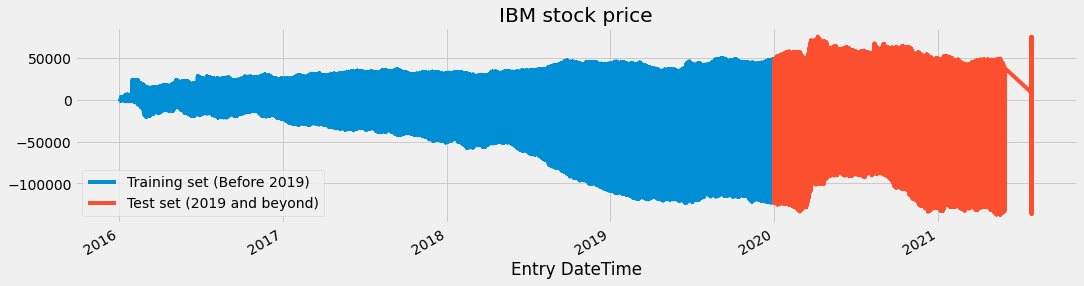

In [192]:
data["Cumulative Profit/Loss (C)"][:'2019'].plot(figsize=(16,4),legend=True)
data["Cumulative Profit/Loss (C)"]['2020':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [193]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [194]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [195]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [196]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 17s 119ms/step - loss: 0.0075
Epoch 2/50
85/85 [==============================] - 10s 119ms/step - loss: 0.0017
Epoch 3/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0010
Epoch 4/50
85/85 [==============================] - 10s 117ms/step - loss: 8.1345e-04
Epoch 5/50
85/85 [==============================] - 10s 118ms/step - loss: 7.0772e-04
Epoch 6/50
85/85 [==============================] - 10s 118ms/step - loss: 7.3076e-04
Epoch 7/50
85/85 [==============================] - 10s 119ms/step - loss: 6.5518e-04
Epoch 8/50
85/85 [==============================] - 10s 119ms/step - loss: 5.6662e-04
Epoch 9/50
85/85 [==============================] - 10s 119ms/step - loss: 4.8713e-04
Epoch 10/50
85/85 [==============================] - 10s 119ms/step - loss: 5.0295e-04
Epoch 11/50
85/85 [==============================] - 10s 118ms/step - loss: 5.0256e-04
Epoch 12/50
85/85 [==============================] - 10s 118ms/s

In [197]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((data["Cumulative Profit/Loss (C)"][:'2019'],data["Cumulative Profit/Loss (C)"]['2020':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [198]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

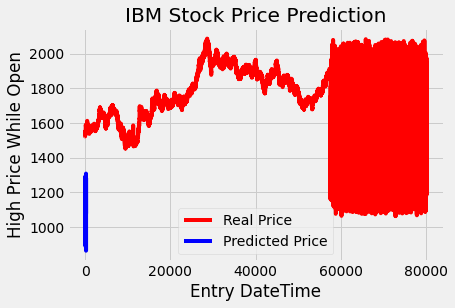

In [199]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [200]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

ValueError: ignored